# Preamble
Import CASA and other necessary bits for this workbook. You can safely ignore the intricacies of the following cell

In [1]:
import sys
import os
import shutil
from IPython.display import display
import ipywidgets as widgets
import tempfile
from casatools import table
tb = table()
import numpy as np
from casatools import quanta
quanta = quanta()
import pyvirtualdisplay
from datetime import datetime
from datetime import timezone
from matplotlib import pyplot as plt

_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

assert os.getenv('DISPLAY') != "" and os.getenv('DISPLAY') is not None
print('X11 Virtual Frame Buffer startup completed')

from casatasks import casalog
currentlogpos = 0
def runcasa(f, *args, **kwargs):
  """
    Runs a CASA task and prints the log
    Args:
      f: task method
      *args: positional arguments to the task f
      **kwargs: named arguments to the task f
    Returns the return value of f or None if failed
  """
  global currentlogpos
  if not os.path.exists(casalog.logfile()):
    with open(casalog.logfile(), "w+") as casalogfile:
      pass
  with open(casalog.logfile(), "r") as casalogfile:
    casalogfile.seek(currentlogpos)
    try:
      res = f(*args, **kwargs)
    finally:
      print(casalogfile.read())
      currentlogpos = casalogfile.tell()
  return res

# define the tasks on the current stack
# and wrap them inside a logger reader
import casatasks
import casatools
import casaplotms
from IPython.display import Image

def wrap_task(mod, tasks):
  for task in tasks:
    def logclosure(task):
      return lambda *args, **kwargs: runcasa(getattr(mod, task),
                                             *args,
                                             **kwargs)
    setattr(sys.modules[__name__], 
        task,
        logclosure(task))
    getattr(sys.modules[__name__], task).__doc__ = \
      getattr(mod, task).__doc__

wrap_task(casatools, ['agentflagger','atcafiller','atmosphere','calanalysis',
                      'calibrater','casadata','coercetype','componentlist',
                      'coordsys','ctsys','ctuser','errors','image','imagemetadata',
                      'imagepol','imager','iterbotsink','linearmosaic','logsink',
                      'measures','miriadfiller','ms','msmetadata','mstransformer',
                      'quanta','regionmanager','sakura','sdm',
                      'sidebandseparator','simulator','singledishms','spectralline',
                      'synthesisdeconvolver','synthesisimager','synthesisimstore',
                      'synthesismaskhandler','synthesisnormalizer','synthesisutils',
                      'table','typecheck','utils','version','version_string',
                      'vlafiller','vpmanager'])

wrap_task(casatasks, ['accor','apparentsens','applycal',
                      'asdmsummary','bandpass',
                      'blcal','calstat',
                      'clearcal',
                      'clearstat','concat','config',
                      'conjugatevis','cvel','cvel2',
                      'delmod','exportasdm','exportfits',
                      'exportuvfits','feather','fixplanets',
                      'fixvis','flagcmd','flagdata','flagmanager',
                      'fluxscale','fringefit','ft','gaincal',
                      'gencal','hanningsmooth','imcollapse',
                      'imcontsub','imdev','imfit','imhead',
                      'imhistory','immath','immoments','impbcor','importasap',
                      'importasdm','importatca','importfits','importfitsidi','importgmrt',
                      'importlib','importmiriad','importnro','importuvfits','importvla',
                      'impv','imrebin','imreframe','imregrid','imsmooth','imstat',
                      'imsubimage','imtrans','imval','initweights','listcal',
                      'listfits','listhistory','listobs','listpartition','listsdm',
                      'listvis','makemask','mstransform','nrobeamaverage',
                      'partition','plotants','plotbandpass','plotprofilemap',
                      'plotweather','polcal','polfromgain','predictcomp','rerefant',
                      'rmfit','rmtables','sdatmcor','sdbaseline','sdcal',
                      'sdfit','sdfixscan','sdgaincal','sdimaging','sdintimaging',
                      'sdpolaverage','sdsidebandsplit','sdsmooth','sdtimeaverage',          
                      'setjy','simalma','simanalyze','simobserve','slsearch','smoothcal',
                      'specfit','specflux','specsmooth','splattotable','split',
                      'spxfit','statwt','tclean','testconcat','tsdimaging','uvcontsub',
                      'uvmodelfit','uvsub','virtualconcat','vishead',
                      'visstat','widebandpbcor'])
wrap_task(casaplotms, ["plotms"])
print('CASA import and initialization completed')

X11 Virtual Frame Buffer startup completed
CASA import and initialization completed


<span style="color:red">!!! Warning: this will erase any modifications you have made / calibrations applied to the dataset since you've run this cell !!!</span>

In [2]:
archive_fn = os.path.join(os.path.abspath(""), "tart.2022.11.22.10-12utc.pp.ms.tar.gz")
MSNAME = os.path.join(os.path.abspath(""), 'tart.ms')
OVERWRITE=True # true if you want to overwrite
##################################
##################################
##################################
if not os.path.exists(archive_fn):
    raise RuntimeError(f"Failed to find archive '{archive_fn}'. Check your git clone")
if OVERWRITE and os.path.exists(MSNAME):
    shutil.rmtree(MSNAME)
if OVERWRITE and os.path.exists(MSNAME+'.flagversions'):
    shutil.rmtree(MSNAME+'.flagversions')
if OVERWRITE:
    !tar xvf {archive_fn}
assert os.path.exists(MSNAME)

tart.ms/
tart.ms/HISTORY/
tart.ms/HISTORY/table.info
tart.ms/HISTORY/table.lock
tart.ms/HISTORY/table.dat
tart.ms/HISTORY/table.f0
tart.ms/table.f6_TSM0
tart.ms/table.f9_TSM0
tart.ms/table.f2_TSM0
tart.ms/DATA_DESCRIPTION/
tart.ms/DATA_DESCRIPTION/table.info
tart.ms/DATA_DESCRIPTION/table.lock
tart.ms/DATA_DESCRIPTION/table.dat
tart.ms/DATA_DESCRIPTION/table.f0
tart.ms/table.f4
tart.ms/table.f3
tart.ms/FIELD/
tart.ms/FIELD/table.f0i
tart.ms/FIELD/table.info
tart.ms/FIELD/table.lock
tart.ms/FIELD/table.dat
tart.ms/FIELD/table.f0
tart.ms/SOURCE/
tart.ms/SOURCE/table.info
tart.ms/SOURCE/table.lock
tart.ms/SOURCE/table.dat
tart.ms/SOURCE/table.f0
tart.ms/table.f3_TSM0
tart.ms/FEED/
tart.ms/FEED/table.f0i
tart.ms/FEED/table.info
tart.ms/FEED/table.lock
tart.ms/FEED/table.dat
tart.ms/FEED/table.f0
tart.ms/table.f8_TSM0
tart.ms/table.info
tart.ms/table.f1
tart.ms/table.f8
tart.ms/table.f5_TSM0
tart.ms/table.f9
tart.ms/POINTING/
tart.ms/POINTING/table.f0i
tart.ms/POINTING/table.info
tart.ms/PO

# Two-element interferometer and linkage to TART 
We first boil the geometry of interferometry down to its most essential subcomponent: a two-element interferometer. Each pair of antennas within a larger interferometer forms a baseline measuring a single spacial frequency of the sky (or visibility). The samples of all such two-element spacings are in the end combined to build up coverage in the synthesized aperture coordinate frame (or $uv$ plane). Shorter baselines contribute measurements to larger scales (resolved Active Galactic Nuclei jets, resolved galactic plane emission, etc.) and longer baselines contribute measurements to finer scales on the sky (distant unresolved point-like AGN for example).

The two-element interferometer measures not only the radiative power from sources, but also the differential delay between the propagated wave reaching the first antenna and the second antenna, from a source radiating in the far field. The delay ($\tau$) is 0 when the source direction vector ($\vec{S}(l,m)$) is aligned with the phase tracking centre ($\vec{S}_0(l,m)$) of the telescope. Due to the limited bandwidth and integration intervals used when correlating the interferometer has a maximal response in all directions orthogonal to the baseline. This is the default phase tracking centre of the telescope.

A single two element interferometer measures both the even (cosine) and the odd (sine) spatial frequencies of the sky brightness distributions -- as they are projected onto the baseline. The product measured, for a perfectly calibrated omni-directional two-element interferometer is a visibility
\begin{equation}
V(u,v,w) = \int_{lm}{I(l,m,\nu)\exp{(-2\pi i\tau/\lambda)} \frac{dldm}{n}}
\end{equation}

The visibility (complex-valued) essentially tells us how resolved a source is at the spatial scale measured by the baseline. An unresolved source is much smaller than the resulting fringe of the longest spacing in the array. It therefore has a constant power across all the composing baselines, whereas a large source is said to be resolved on a baseline if it is spacially much larger than the fringe period of that spacing (ie. the integral over the fringes tends to 0 across the extent of the source).

In practice we can use the Fourier shift theorem to change the tracking centre of our telescope to have zero phase towards any point on the celestial sphere. This is done by adding in an additional delay to the geometric phase. The net effect tilts each of the composing two-element interferometers to have a 0 phase towards a new point, $\vec{S}_i(l,m)$. In large interferometers this geometric term shifts much quicker than the integration interval and is done inside the correlator. On TART the resolution is poor, which means that the integration interval (adjustable, but on the orders of a few seconds) is substantially shorter than the time it takes for a source to move even a fraction of the instrumental resolution due to Earth rotation. We can therefore apply the term after correlation.

Lastly, the signal path is never perfectly calibrated. for a single feed system we can write the visibility term with complex valued gains (equivalently Jones matrices in orthogonal feeds). These are subscribed by $p$ and $q$ for arbitrary antennas $p$ and $q$. These terms can be cable delays (phase slopes as a function of frequency), time-variable phases and amplitudes due to the electronics and ionospheric phase (at cm-wavelengths). These gains apply equally to all areas of the observed sky and are called direction-independent (or second-generation) effects. The following is an example of such a Radio Interferometric Measurement Equation (RIME). 
\begin{equation}
V(u,v,w) = G_p(t,\nu)\int_{lm}{I(l,m,\nu)\exp{(-2\pi i\tau/\lambda)} \frac{dldm}{n}}G^H_q(t,\nu)
\end{equation}

We can add additional direction-dependent (or third-generation) terms. The most prominent of these is the far field response of the antennas, which is (approximately) the Fourier transform of the voltage grading function on the antenna collecting surface and may not be uniformly sensitive over the entire field of view. We will call the far field responses $E_p(l,m,\nu)$ and $E_q(l,m,\nu)$. The RIME then becomes a bit more complicated
\begin{equation}
\begin{split}
V(u,v,w) = G_p(t,\nu)\int_{lm}{E_p(l,m,\nu)I(l,m,\nu)\exp{(-2\pi i\tau/\lambda)E^H_q(l,m,\nu)} \frac{dldm}{n}}G^H_q(t,\nu)
\end{split}
\end{equation}

Telescope calibration attempts to remove these complex gain terms. This will be the topic of discussion in this notebook and have to be applied before images can be made. We will use the Common Astronomy Software Applications (CASA) version 6.5 to correct for these terms.

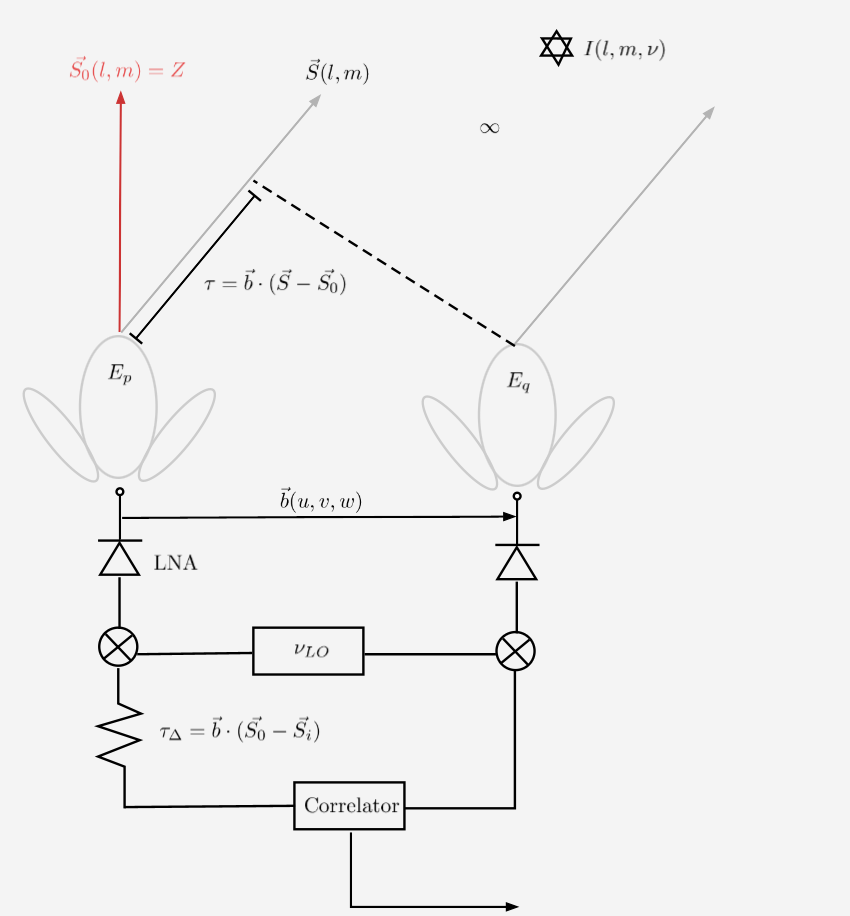

In [3]:
Image(os.path.join(os.path.abspath(""), "imgs", "two.element.interferometer.png"))

With the component two-element interferometer in hand we can look at the distribution of visibilities in the synthesized aperture plane that results from observation with an array interferometer. Remember that the tracking coordinates are defined as offsets to the celestial frame (X pointing towards the meridian at the celestial equator, Y pointing East and Z pointing towards celestial north).
\begin{equation}
\begin{pmatrix}
u \\
v \\
w
\end{pmatrix} = \begin{pmatrix} 
\sin(H_0) & \cos(H_0) & 0 \\
-\sin(\delta_0)\cos(H_0) & \sin(\delta_0)\sin(H_0) & \cos(\delta_0) \\
\cos(\delta_0)\cos(H_0) & -\cos(\delta_0)\sin(H_0) & \sin(\delta_0)
\end{pmatrix}\begin{pmatrix} 
X \\
Y \\
Z
\end{pmatrix}
\end{equation}

$w$ is tilted from the nominal XYZ celestial frame to point towards the tracking centre of the telescope. As the $u$ and $v$ bases are functions of hour angle the baseline coordinates track out a virtual aperture the size of the longest baseline in what is appropriately termed the $uv$ plane. 

We plot the projected $uv(w=0)$ plane for our observation below. For each spacing in this synthesized aperture plane we also get the conjugate spacing for free. As the spatial distribution of power in the sky is real-valued we only need to keep either the baselines or their conjugates.

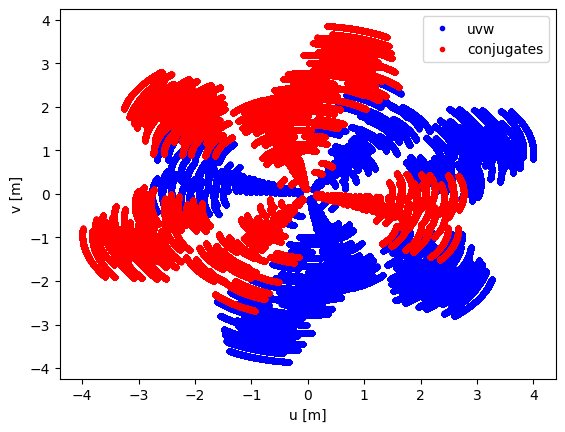

In [4]:
tb.open("tart.ms")
uvw = tb.getcol('UVW').T
tb.close()
plt.figure()
plt.plot(uvw[:,0], uvw[:,1], 'b.', label='uvw')
plt.plot(-uvw[:,0], -uvw[:,1], 'r.', label='conjugates')
plt.xlabel('u [m]')
plt.ylabel('v [m]')
plt.legend()
plt.show()

We now take a look at what is contained in the database through standard CASA tasks. We use the listobs task to see the a summary of the observation. We can see that the TART operates at the centre of the GPS L1 band and the observation total exposure is about an hour. We have rephased the visibilities to the mid-point of the observation (16h50m47s -33d16m48s J2000). There are 24 antennas in the array.

In [5]:
listobs(vis="tart.ms", verbose=False)

2023-10-10 07:57:12	INFO	::casa	
2023-10-10 07:57:12	INFO	::casa	
2023-10-10 07:57:12	INFO	::casa	
2023-10-10 07:57:13	INFO	::casa	
2023-10-10 07:57:14	INFO	::casa	Python version 3.8.10
2023-10-10 07:57:14	INFO	::casa	CASA Version MODULAR 6.5.6.22
2023-10-10 07:57:14	INFO	::casa	Can't import casatelemetry module.
2023-10-10 07:57:43	INFO	listobs::::casa	##########################################
2023-10-10 07:57:43	INFO	listobs::::casa	##### Begin Task: listobs            #####
2023-10-10 07:57:43	INFO	listobs::::casa	listobs( vis='tart.ms', selectdata=True, spw='', field='', antenna='', uvrange='', timerange='', correlation='', scan='', intent='', feed='', array='', observation='', verbose=False, listfile='', listunfl=False, cachesize=50.0, overwrite=False )
2023-10-10 07:57:44	INFO	listobs::ms::summary	================================================================================
2023-10-10 07:57:44	INFO	listobs::ms::summary+	           MeasurementSet Name:  /home/bhugo/workspace/n

{'BeginTime': 59905.41666950006,
 'EndTime': 59905.499299755546,
 'IntegrationTime': 7139.25407409668,
 'field_0': {'code': '',
  'direction': {'m0': {'unit': 'rad', 'value': -1.8728111669477985},
   'm1': {'unit': 'rad', 'value': -0.5808456540523018},
   'refer': 'J2000',
   'type': 'direction'},
  'name': 'J165047-331648'},
 'nfields': 1,
 'numrecords': 1888116,
 'scan_1': {'0': {'BeginTime': 59905.41666950006,
   'EndTime': 59905.499299755546,
   'FieldId': 0,
   'FieldName': 'J165047-331648',
   'IntegrationTime': 1.0235366821289062,
   'SpwIds': array([0]),
   'StateId': 0,
   'nRow': 1888116,
   'scanId': 1}},
 'timeref': 'UTC'}

We always start off by inspecting what has already been flagged and to backup our flags

*Important: ALWAYS backup your flags for operations modifying the flags*

In [6]:
flagdata(vis='tart.ms',mode='summary')

2023-10-10 07:57:46	INFO	flagdata::::casa	##########################################
2023-10-10 07:57:46	INFO	flagdata::::casa	##### Begin Task: flagdata           #####
2023-10-10 07:57:46	INFO	flagdata::::casa	flagdata( vis='tart.ms', mode='summary', autocorr=False, inpfile='', reason='any', tbuff=0.0, spw='', field='', antenna='', uvrange='', timerange='', correlation='', scan='', intent='', array='', observation='', feed='', clipminmax=[], datacolumn='DATA', clipoutside=True, channelavg=False, chanbin=1, timeavg=False, timebin='0s', clipzeros=False, quackinterval=1.0, quackmode='beg', quackincrement=False, tolerance=0.0, addantenna='', lowerlimit=0.0, upperlimit=90.0, ntime='scan', combinescans=False, timecutoff=4.0, freqcutoff=3.0, timefit='line', freqfit='poly', maxnpieces=7, flagdimension='freqtime', usewindowstats='none', halfwin=1, extendflags=True, winsize=3, timedev='', freqdev='', timedevscale=5.0, freqdevscale=5.0, spectralmax=1000000.0, spectralmin=0.0, antint_ref_antenna

{'antenna': {'ANTENNA-0': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-1': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-10': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-11': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-12': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-13': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-14': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-15': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-16': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-17': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-18': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-19': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-2': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-20': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-21': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-22': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-23': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-3': {'flagged': 0.0, 'total': 157343.0},
  'ANTENNA-4': {'flagged': 0.0, 'total'

In [7]:
flagmanager(vis='tart.ms', versionname='original', mode='save')

2023-10-10 07:58:03	INFO	flagmanager::::casa	##########################################
2023-10-10 07:58:03	INFO	flagmanager::::casa	##### Begin Task: flagmanager        #####
2023-10-10 07:58:03	INFO	flagmanager::::casa	flagmanager( vis='tart.ms', mode='save', versionname='original', oldname='', comment='', merge='replace' )
2023-10-10 07:58:03	INFO	flagmanager::AgentFlagger::open	Table type is Measurement Set
2023-10-10 07:58:03	INFO	flagmanager::::casa	Save current flagversions to original
2023-10-10 07:58:03	INFO	FlagVersion::saveFlagVersion	Creating new backup flag file called original
2023-10-10 07:58:08	INFO	flagmanager::::casa	Task flagmanager complete. Start time: 2023-10-10 09:58:03.034633 End time: 2023-10-10 09:58:07.597424
2023-10-10 07:58:08	INFO	flagmanager::::casa	##### End Task: flagmanager          #####
2023-10-10 07:58:08	INFO	flagmanager::::casa	##########################################



We can also look at the array configuration. The TART at Rhodes is about a 1/1000th of the size of the VLA in a very similar Y-shaped configuration 

/home/bhugo/workspace/venvtart/lib/python3.8/site-packages/casatasks/private/task_plotants.py:356: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


2023-10-10 07:58:08	INFO	plotants::::casa	##########################################
2023-10-10 07:58:08	INFO	plotants::::casa	##### Begin Task: plotants           #####
2023-10-10 07:58:08	INFO	plotants::::casa	plotants( vis='tart.ms', figfile='', antindex=False, logpos=False, exclude='', checkbaselines=False, title='', showgui=True )
2023-10-10 07:58:08	INFO	msmetadata_cmpt.cc::open	Performing internal consistency checks on tart.ms...
2023-10-10 07:58:08	INFO	plotants::::casa	Number of points being plotted: 24
2023-10-10 07:58:08	INFO	plotants::::casa	Task plotants complete. Start time: 2023-10-10 09:58:07.627224 End time: 2023-10-10 09:58:08.358367
2023-10-10 07:58:08	INFO	plotants::::casa	##### End Task: plotants             #####
2023-10-10 07:58:08	INFO	plotants::::casa	##########################################



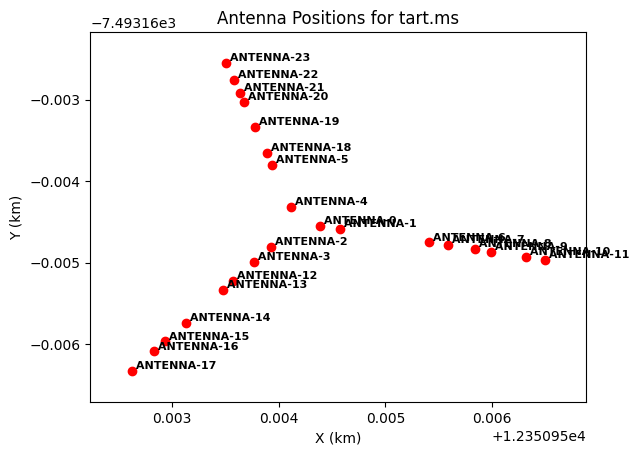

In [8]:
plotants(vis='tart.ms')

We can also use standard tasks to see what the $uv$ coverage looks like via the very versatile plotms command

2023-10-10 07:58:13	WARN	MSTransformManager::checkDataColumnsToFill	No datacolumn selected in buffer mode


NOTICE: Exporting to images in screen resolution is currently not working.  Switching to high resolution (which is slower, but works).
2023-10-10 07:58:10	INFO	plotms::::casa	##########################################
2023-10-10 07:58:10	INFO	plotms::::casa	##### Begin Task: plotms             #####
2023-10-10 07:58:10	INFO	plotms::::casa	plotms( vis='tart.ms', gridrows=1, gridcols=1, rowindex=0, colindex=0, plotindex=0, xaxis='U', xdatacolumn='', xframe='', xinterp='', yaxis='V', ydatacolumn='', yframe='', yinterp='', yaxislocation='', selectdata=True, field='', spw='', timerange='', uvrange='', antenna='', scan='', correlation='', array='', observation='', intent='', feed='', msselect='', averagedata=True, avgchannel='', avgtime='', avgscan=False, avgfield=False, avgbaseline=False, avgantenna=False, avgspw=False, scalar=False, transform=True, freqframe='', restfreq='', veldef='RADIO', phasecenter='', extendflag=False, extcorr=False, extchannel=False, iteraxis='', xselfscale=False, ys

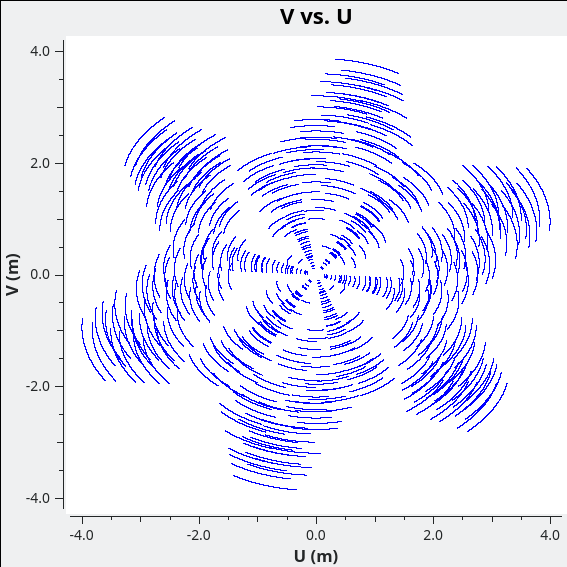

In [9]:
plotms(vis='tart.ms', xaxis="U", yaxis="V", showgui=False, plotfile='uvcoverage.tart.png', overwrite=True)
Image(os.path.join(os.path.abspath(""), 'uvcoverage.tart.png'))

We can now calibrate our data. The process of calibration is typically done as an optimization problem (aside from a few of the terms, where a model is not strictly required, but assumptions are made about the field being observed). TART amplitudes are not corrected to any fixed flux scale that can be related back to a temperature. We minimize, for instance the following optimization problem for a standard time-variable direction-independent solution:

\begin{equation}
\epsilon = |V_\text{model}(u,v) - G_p(t)V_\text{raw}(u,v)G^H_q(t)|^2 (\forall p,q \in \{\text{antennas}\})
\end{equation}

The model we are using here are the TLE positions of the satellites (each assumed to be scaled to an arbitrary value of unity, as a first order model of the satellites (which are all unresolved by our small interferometer). This model is already fetched from the TART satellite TLE API and predicted via Direct Fourier Transform by the tart2ms software for the user's convenience. The model data is stored in the MODEL_DATA column. For a sensitive large array these first order solutions will come from known quasar fields and transfer interpolated onto target through a process of transfer (or first-generation) calibration.

Let's have a first pass look at the antenna gain amplitudes. We disable the SNR clip on the calibration software due to the TART's very limited sensitivity.

2023-10-10 07:58:42	INFO	gaincal::::casa	##########################################
2023-10-10 07:58:42	INFO	gaincal::::casa	##### Begin Task: gaincal            #####
2023-10-10 07:58:42	INFO	gaincal::::casa	gaincal( vis='tart.ms', caltable='tart.G0a', field='', spw='', intent='', selectdata=True, timerange='', uvrange='', antenna='', scan='', observation='', msselect='', solint='300s', combine='', preavg=-1.0, refant='', refantmode='flex', minblperant=4, minsnr=1e-06, solnorm=False, normtype='mean', gaintype='G', smodel=[], calmode='a', solmode='', rmsthresh=[], corrdepflags=False, append=False, splinetime=3600.0, npointaver=3, phasewrap=180.0, docallib=False, callib='', gaintable=[], gainfield=[], interp=[], spwmap=[], parang=False )
2023-10-10 07:58:42	INFO	gaincal::calibrater::open	****Using NEW VI2-driven calibrater tool****
2023-10-10 07:58:42	INFO	gaincal::calibrater::open	Opening MS: tart.ms for calibration.
2023-10-10 07:58:42	INFO	gaincal::Calibrater::	Initializing nominal s

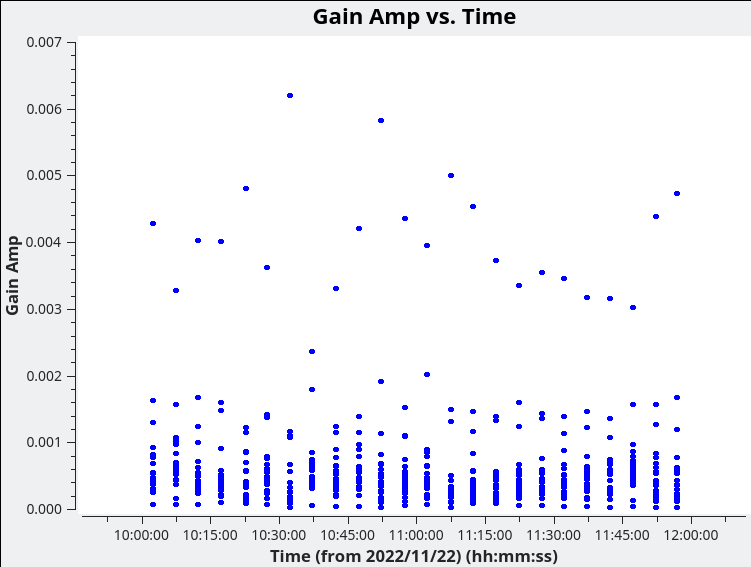

In [10]:
gaincal(vis="tart.ms", calmode="a", caltable="tart.G0a", solint="300s", minsnr=1e-6)
plotms(vis="tart.G0a", xaxis="time", yaxis="GainAmp", showgui=False, plotfile='gainamp.unflagged.tart.png', overwrite=True)
Image(os.path.join(os.path.abspath(""), 'gainamp.unflagged.tart.png'))


Antenna row-index 14 in the ::ANTENNA keyword table (name ANTENNA-14 in this instance) appears to be very noisy and likely has an issue somewhere along the low noise amplification or analog connection path. We can easily see this by plotting the (per antenna) solutions as a function of antenna index. Lets' flag it out and then resolve for phases as well. In CASA the flagging task will automatrically backup the previous flag set.

NOTICE: Exporting to images in screen resolution is currently not working.  Switching to high resolution (which is slower, but works).
2023-10-10 08:00:59	INFO	plotms::::casa	##########################################
2023-10-10 08:00:59	INFO	plotms::::casa	##### Begin Task: plotms             #####
2023-10-10 08:00:59	INFO	plotms::::casa	plotms( vis='tart.G0a', gridrows=1, gridcols=1, rowindex=0, colindex=0, plotindex=0, xaxis='antenna1', xdatacolumn='', xframe='', xinterp='', yaxis='GainAmp', ydatacolumn='', yframe='', yinterp='', yaxislocation='', selectdata=True, field='', spw='', timerange='', uvrange='', antenna='', scan='', correlation='', array='', observation='', intent='', feed='', msselect='', averagedata=True, avgchannel='', avgtime='', avgscan=False, avgfield=False, avgbaseline=False, avgantenna=False, avgspw=False, scalar=False, transform=True, freqframe='', restfreq='', veldef='RADIO', phasecenter='', extendflag=False, extcorr=False, extchannel=False, iteraxis='', xselfs

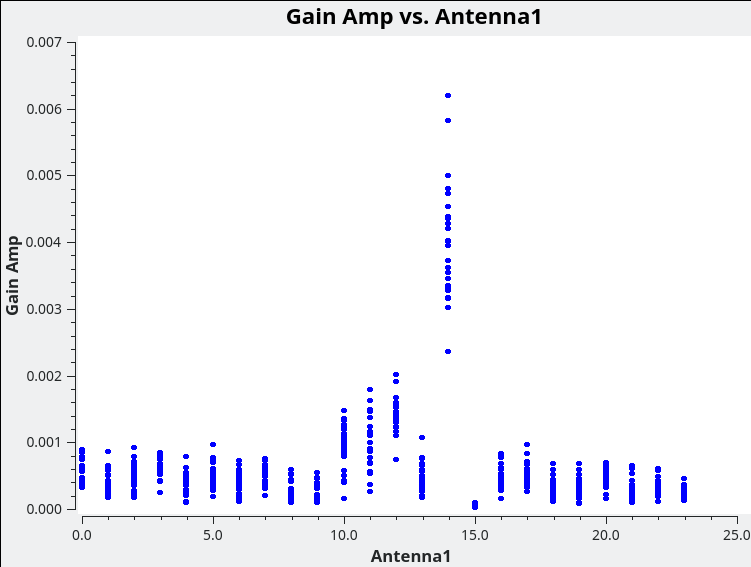

In [11]:
plotms(vis="tart.G0a", xaxis="antenna1", yaxis="GainAmp", showgui=False, plotfile='gainamp.unflagged.14.tart.png', overwrite=True)
Image(os.path.join(os.path.abspath(""),'gainamp.unflagged.14.tart.png'))

In [12]:
flagdata(vis='tart.ms',mode='manual',antenna="14")
gaincal(vis="tart.ms", calmode="a", caltable="tart.G0a", solint="300s", minsnr=1e-6)
gaincal(vis="tart.ms", calmode="p", caltable="tart.G0p", solint="30s", minsnr=1e-6, gaintable=["tart.G0a"])

2023-10-10 08:01:00	INFO	flagdata::::casa	##########################################
2023-10-10 08:01:00	INFO	flagdata::::casa	##### Begin Task: flagdata           #####
2023-10-10 08:01:00	INFO	flagdata::::casa	flagdata( vis='tart.ms', mode='manual', autocorr=False, inpfile='', reason='any', tbuff=0.0, spw='', field='', antenna='14', uvrange='', timerange='', correlation='', scan='', intent='', array='', observation='', feed='', clipminmax=[], datacolumn='DATA', clipoutside=True, channelavg=False, chanbin=1, timeavg=False, timebin='0s', clipzeros=False, quackinterval=1.0, quackmode='beg', quackincrement=False, tolerance=0.0, addantenna='', lowerlimit=0.0, upperlimit=90.0, ntime='scan', combinescans=False, timecutoff=4.0, freqcutoff=3.0, timefit='line', freqfit='poly', maxnpieces=7, flagdimension='freqtime', usewindowstats='none', halfwin=1, extendflags=True, winsize=3, timedev='', freqdev='', timedevscale=5.0, freqdevscale=5.0, spectralmax=1000000.0, spectralmin=0.0, antint_ref_antenn

{'apply_tables': array(['tart.G0a'], dtype='<U8'),
 'selectvis': {'antennas': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23]),
  'field': array([0]),
  'intents': array([], dtype='<U5'),
  'observation': array([0]),
  'scan': array([1]),
  'spw': array([0])},
 'solve_tables': array(['tart.G0p'], dtype='<U8'),
 'solvestats': {'above_minblperant': array([236, 236]),
  'above_minsnr': array([236, 236]),
  'data_unflagged': array([236, 236]),
  'expected': array([236, 236]),
  'spw0': {'above_minblperant': array([236, 236]),
   'above_minsnr': array([236, 236]),
   'ant0': {'above_minblperant': array([236, 236]),
    'above_minsnr': array([236,   0]),
    'data_unflagged': array([236, 236]),
    'expected': array([236, 236]),
    'used_as_refant': array([0])},
   'ant1': {'above_minblperant': array([236, 236]),
    'above_minsnr': array([236,   0]),
    'data_unflagged': array([236, 236]),
    'expected': array([236, 236]),
 

NOTICE: Exporting to images in screen resolution is currently not working.  Switching to high resolution (which is slower, but works).
2023-10-10 08:06:07	INFO	plotms::::casa	##########################################
2023-10-10 08:06:07	INFO	plotms::::casa	##### Begin Task: plotms             #####
2023-10-10 08:06:07	INFO	plotms::::casa	plotms( vis='tart.G0p', gridrows=1, gridcols=1, rowindex=0, colindex=0, plotindex=0, xaxis='time', xdatacolumn='', xframe='', xinterp='', yaxis='GainPhase', ydatacolumn='', yframe='', yinterp='', yaxislocation='', selectdata=True, field='', spw='', timerange='', uvrange='', antenna='', scan='', correlation='', array='', observation='', intent='', feed='', msselect='', averagedata=True, avgchannel='', avgtime='', avgscan=False, avgfield=False, avgbaseline=False, avgantenna=False, avgspw=False, scalar=False, transform=True, freqframe='', restfreq='', veldef='RADIO', phasecenter='', extendflag=False, extcorr=False, extchannel=False, iteraxis='antenna', x

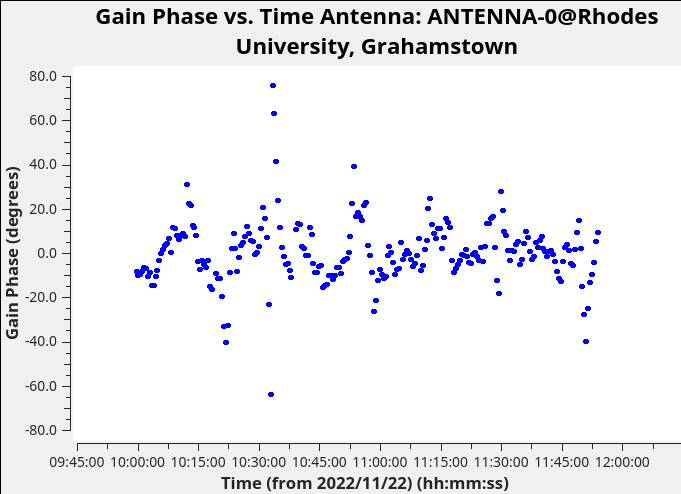

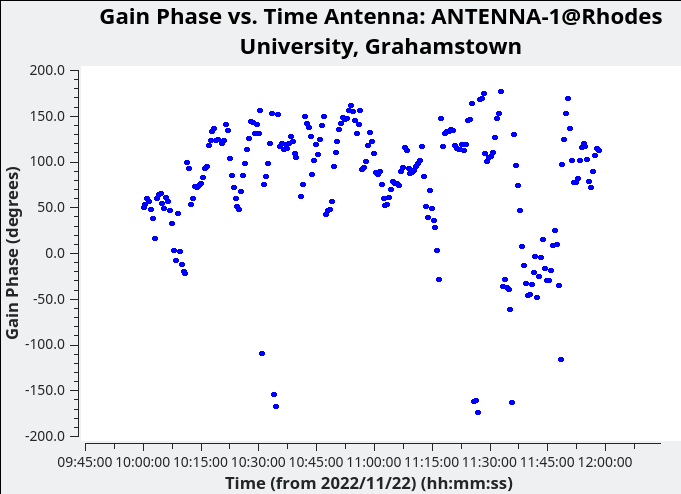

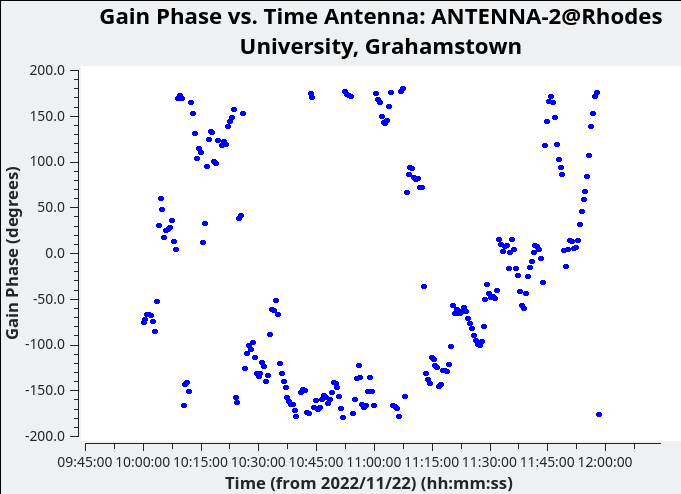

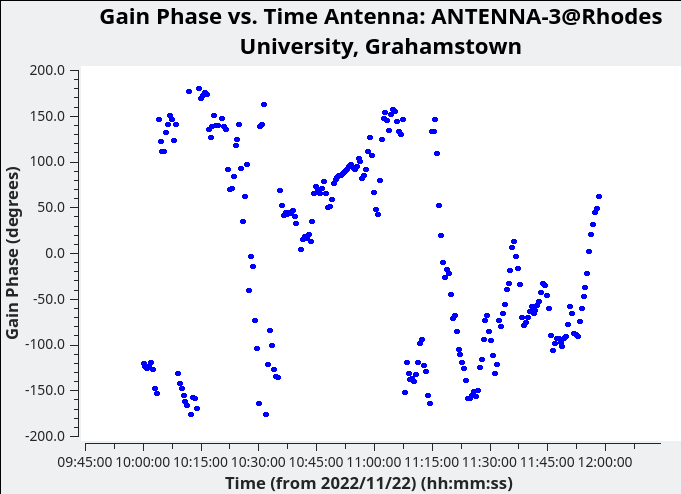

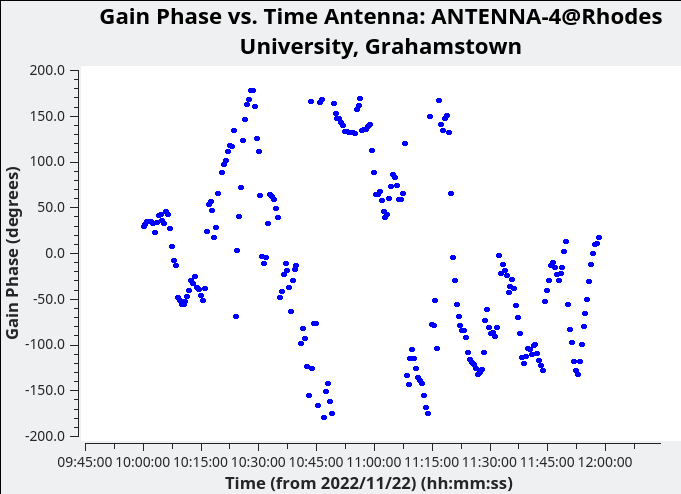

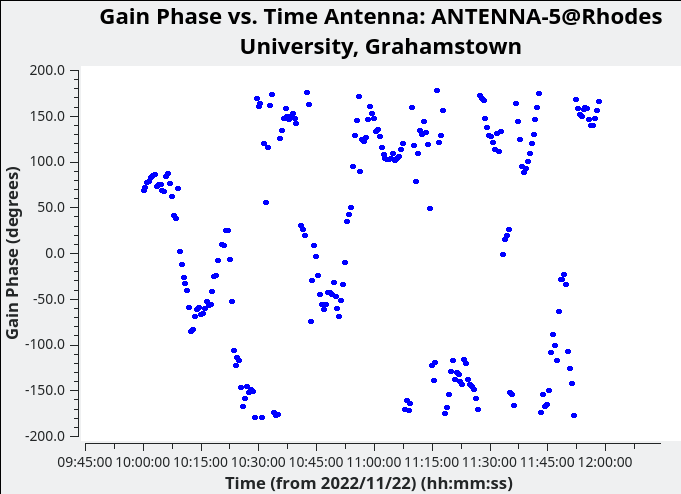

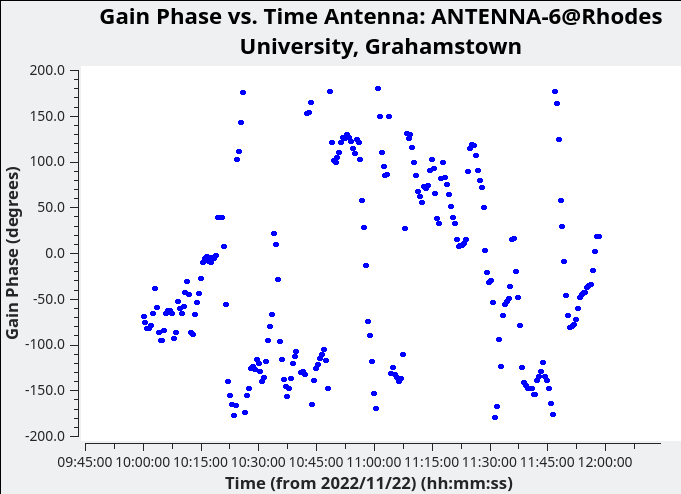

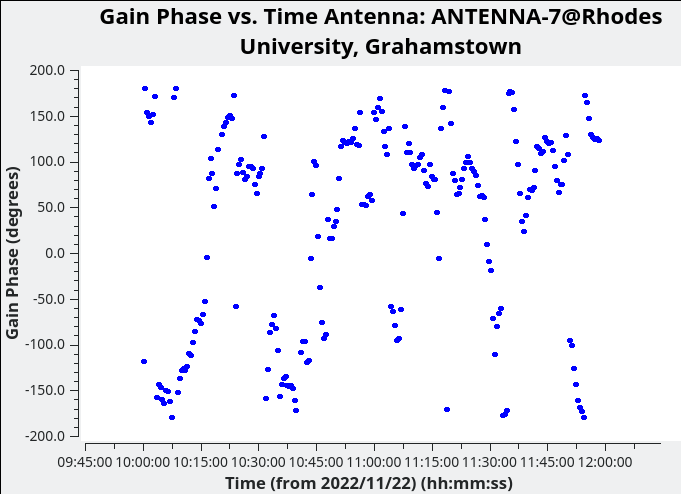

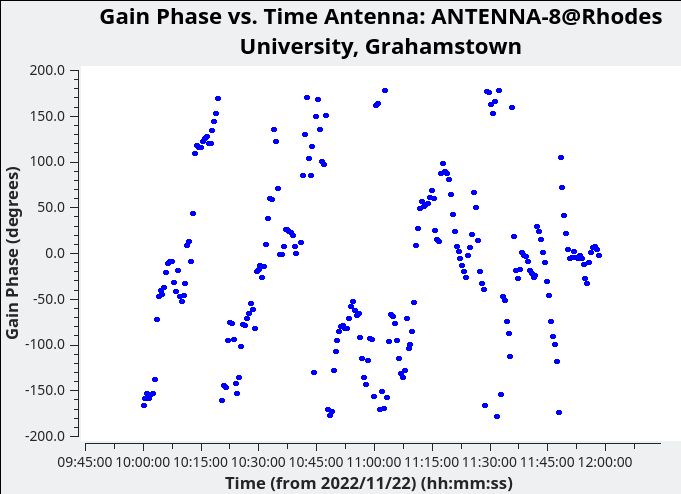

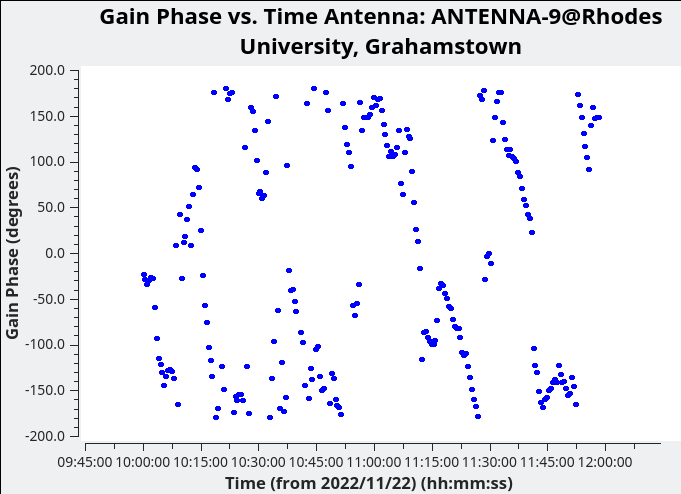

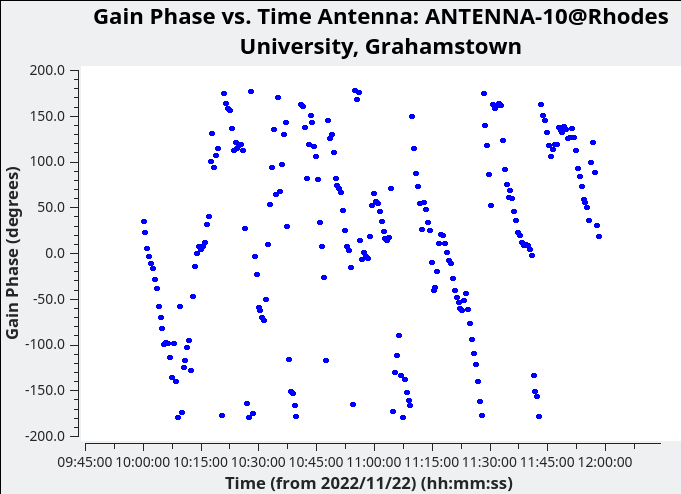

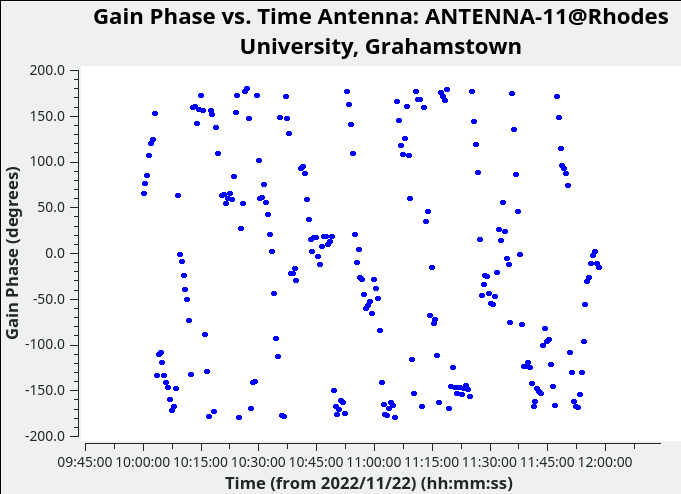

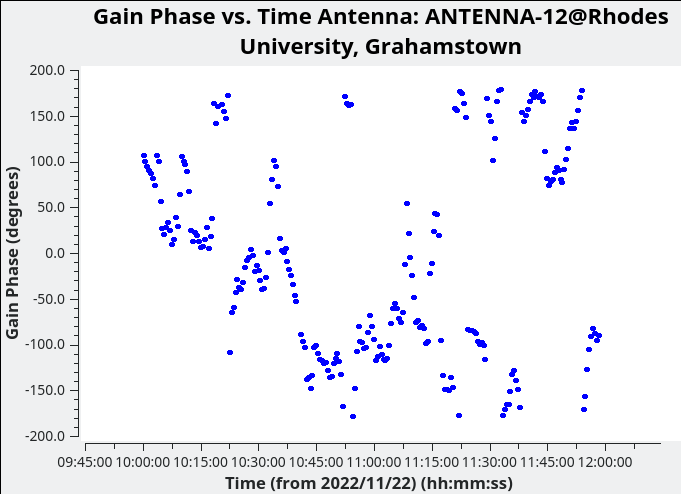

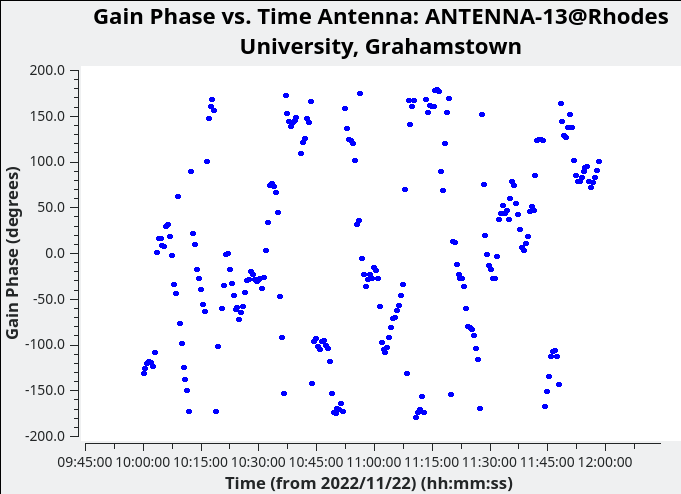

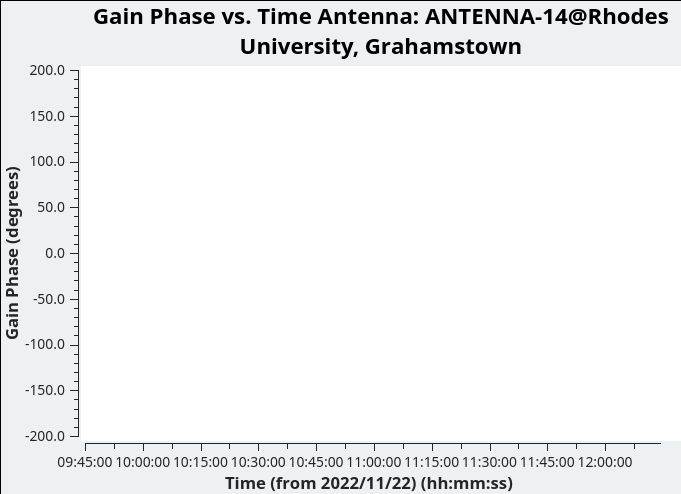

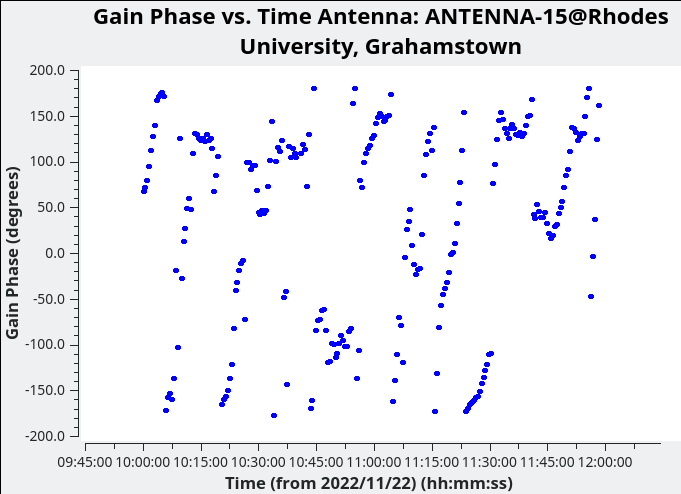

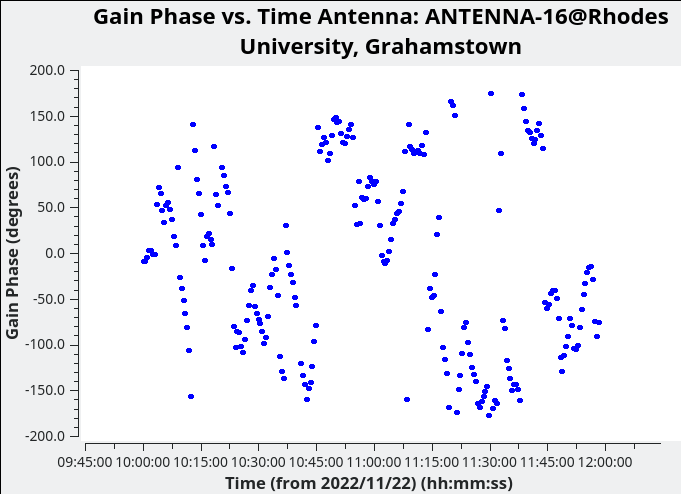

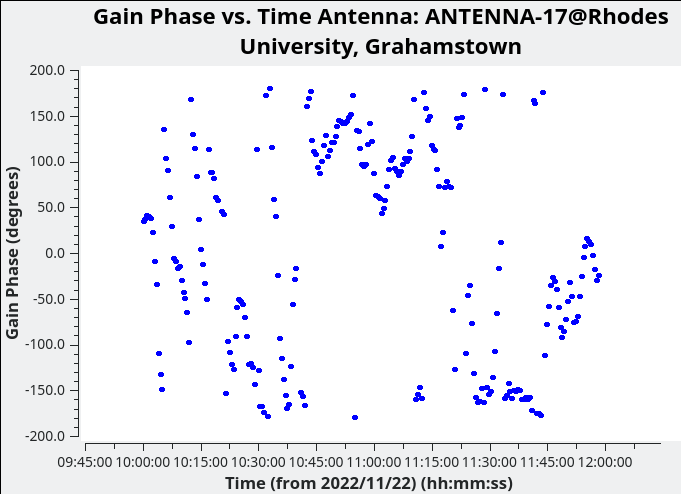

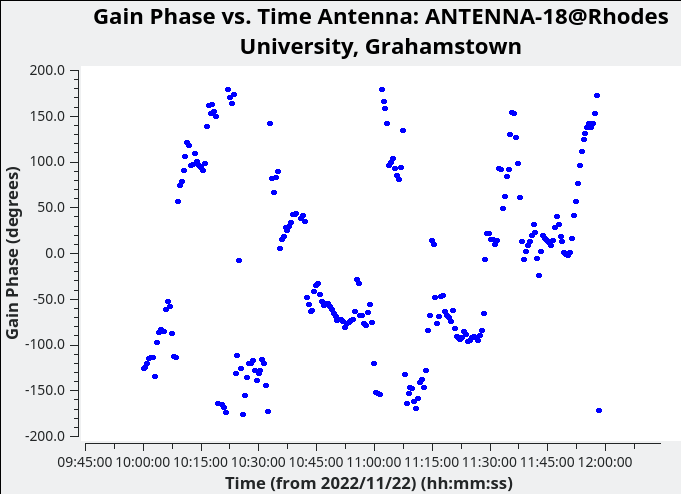

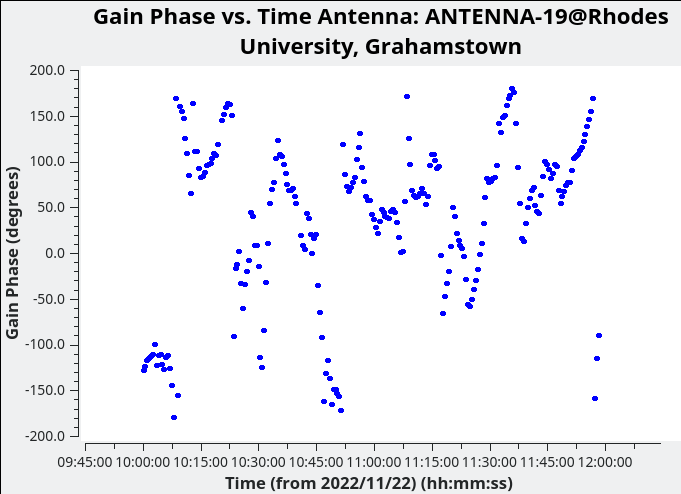

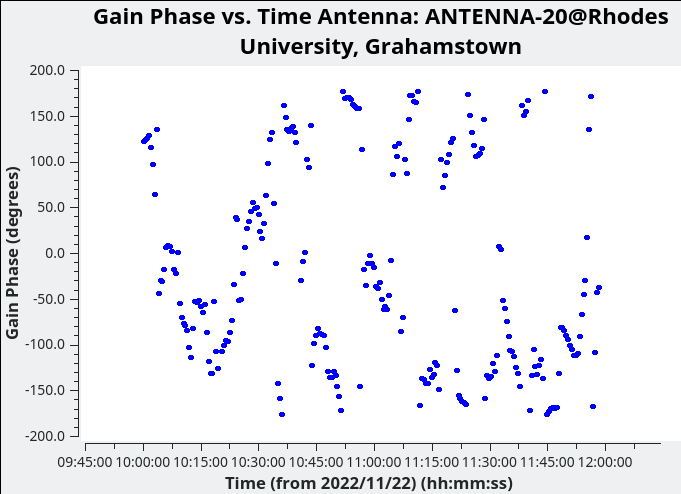

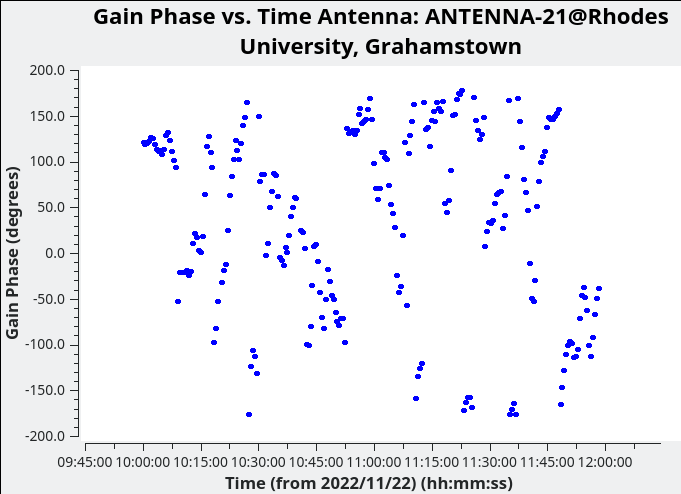

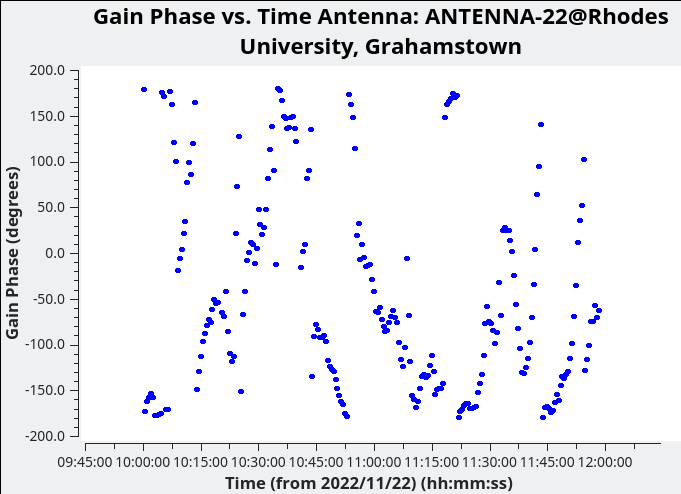

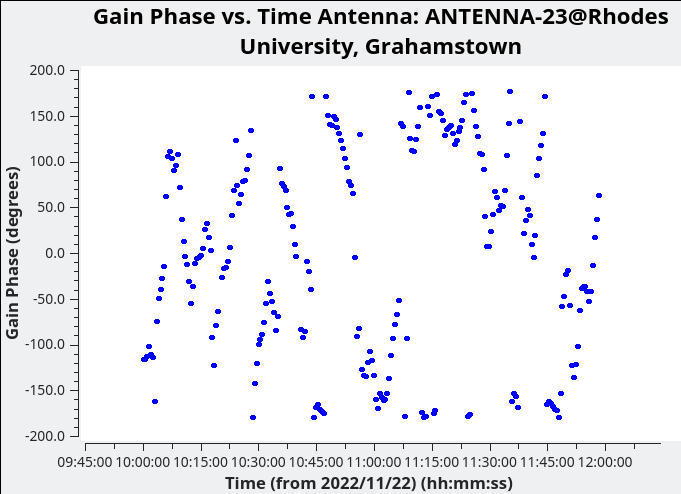

In [13]:
plotms(vis="tart.G0p", xaxis="time", yaxis="GainPhase", iteraxis="antenna",plotfile='gainphase.tart.png', overwrite=True, exprange='all')
for ai in range(24):
    i = Image(os.path.join(os.path.abspath(""),f"gainphase.tart_AntennaANTENNA-{ai}@Rhodes University, Grahamstown{'_'+str(ai+1) if ai>0 else ''}.png"))
    display(i)

## Discussion point
Can we guess what is going wrong with the Rhodes TART -- those phases are very unstable!

Let's apply calibration and image

In [14]:
applycal(vis="tart.ms", gaintable=["tart.G0a", "tart.G0p"])

2023-10-10 08:06:18	INFO	applycal::::casa	##########################################
2023-10-10 08:06:18	INFO	applycal::::casa	##### Begin Task: applycal           #####
2023-10-10 08:06:18	INFO	applycal::::casa	applycal( vis='tart.ms', field='', spw='', intent='', selectdata=True, timerange='', uvrange='', antenna='', scan='', observation='', msselect='', docallib=False, callib='', gaintable=['tart.G0a', 'tart.G0p'], gainfield=[], interp=[], spwmap=[], calwt=[True], parang=False, applymode='', flagbackup=True )
2023-10-10 08:06:18	INFO	applycal::calibrater::open	****Using NEW VI2-driven calibrater tool****
2023-10-10 08:06:18	INFO	applycal::calibrater::open	Opening MS: tart.ms for calibration.
2023-10-10 08:06:18	INFO	applycal::VisSetUtil::addScrCols	Adding CORRECTED_DATA column(s).
2023-10-10 08:06:30	INFO	applycal::VisSetUtil::addScrCols	Start copying column keyword(s) of CORRECTED_DATA from DATA
2023-10-10 08:06:30	INFO	applycal::Calibrater::	Initializing nominal selection to the w

In [21]:
imgs_tart_dir = os.path.join(os.path.abspath(""),'imgs_tart')
if os.path.exists(imgs_tart_dir):
    shutil.rmtree(imgs_tart_dir)
!mkdir {imgs_tart_dir}
!OPENBLAS_NUM_THREADS=1 wsclean -name {imgs_tart_dir}/tart_robust_0.5 -mem 50 -weight briggs 0.5 -data-column CORRECTED_DATA -size 1024 1024 -scale 600asec -channels-out 1 -pol RR -niter 2000 -gain 0.1 -mgain 0.95 -padding 1.5 -auto-mask 5 -no-update-model-required -field 0 -intervals-out 60 tart.ms


WSClean version 3.1.0 (2022-04-01)
This software package is released under the GPL version 3.
Author: André Offringa (offringa@gmail.com).

=== IMAGING TABLE ===
       # Pol Ch JG ²G FG FI In Freq(MHz)
| Independent group:
+-+-J- 0  RR   0  0  0  0  0  0  1574-1577 (1)
Counting number of scans... DONE (6841)
Determining first and last row index... DONE (0-31464)
Reordering tart.ms into 1 x 1 parts.
Reordering: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
Initializing model visibilities: 0%....10%....20%....30%....40%....50%....60%....70%....80%....90%....100%
 == Constructing PSF ==
Precalculating weights for Briggs'(0.5) weighting...
Opening reordered part 0 spw 0 for tart.ms
Detected 62.6 GB of system memory, usage limited to 31.3 GB (frac=50%, no limit)
Opening reordered part 0 spw 0 for tart.ms
Determining min and max w & theoretical beam size... DONE (w=[0.0104324:4.39524] lambdas, maxuvw=21.8228 lambda)
Theoretic beam = 2.63 deg
Minimal inversion si